In [8]:
import matplotlib, sys,  os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append("./mylib/")
sys.path.append("../../Env/")

import numpy as np
import matplotlib.pyplot as plt

np.seterr(all="ignore")
from threeML import *
from WCDA_hal import HAL, HealpixConeROI, HealpixMapROI
import traceback
silence_warnings()
import warnings
warnings.simplefilter("ignore")
silence_warnings()
from threeML import silence_progress_bars, activate_progress_bars, toggle_progress_bars
from threeML.utils.progress_bar import trange

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.visualization import astropy_mpl_style, imshAow_norm
from astropy.coordinates import Angle

import healpy as hp

from tqdm import tqdm

# from mylib import *
import mylib as my
from importlib import reload

Load sub from Myspeedup: : 34it [00:16, 207.63it/s]

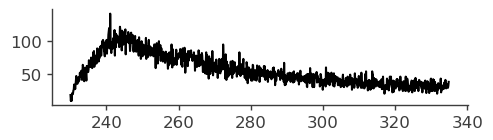

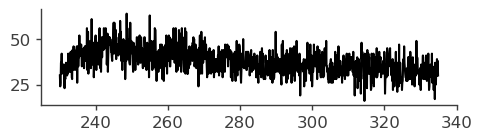

100%|██████████| 7000/7000 [00:00<00:00, 11497.82it/s]


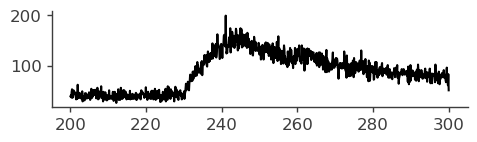

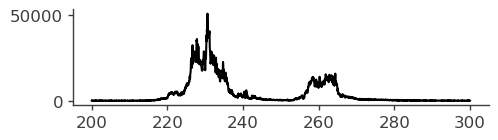

In [31]:
%matplotlib inline
GRB221009A = my.lc("../../data/lc_data/GRB221009A/GRBlcunbin.root", ebin=11, funcfile="../../data/lc_data/GRB221009A/bkg.npy")
GRB221009A.rebin(1000)
GRB221009A.drawlc()
GRB221009A_trig = my.lc("../../data/lc_data/GRB221009A/1009_nf_dt.root", tname="h;1")
GRB221009A_trig.rebin(1000)
GRB221009A_trig.drawlc()
GRB221009Aall = GRB221009A + GRB221009A_trig
GRB221009Aall.drawlc(200,300)
GRB221009A_prompr = my.lc('../../data/lc_data/GRB221009A/hebs-2.txt')
GRB221009A_prompr.drawlc(200,300)

In [87]:
datafgrb = GRB221009Aall.getdatafram()
datafgrb = datafgrb[(datafgrb["x"]>=230) & (datafgrb["x"]<=600)]

00:39:01 INFO      Using Poisson log-likelihood                                                       ]8;id=894256;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/plugins/XYLike.py\XYLike.py]8;;\:]8;id=373204;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/plugins/XYLike.py#115\115]8;;\

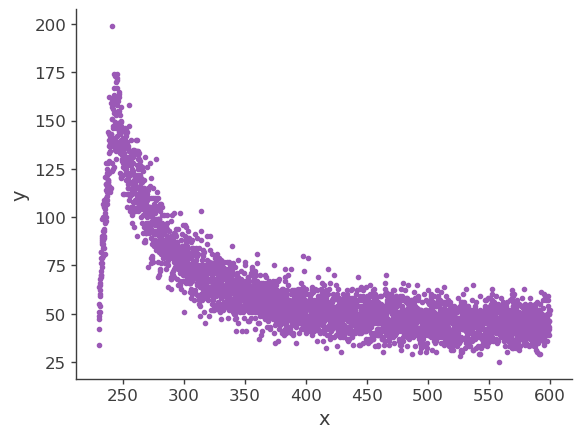

In [88]:
GRBlike = XYLike.from_dataframe("GRB221009A", datafgrb, poisson=True)
fig = GRBlike.plot()

In [89]:
lcmodel = my.SBPL()
src = PointSource("GRB221009A", ra=0.0, dec=0.0, spectral_shape=lcmodel)
lcmodel.alpha1.bounds = (0,5)
lcmodel.alpha2.bounds = (-5,0)
lcmodel.F0.bounds = (0.1,1000)
lcmodel.t0.bounds = (225, 235)
model = Model(src)
data = DataList(GRBlike)
model

Model summary:
==============

                  N
Point sources     1
Extended sources  0
Particle sources  0

Free parameters (6):
--------------------

                                      value min_value max_value   
GRB221009A.spectrum.main.SBPL.F0      100.0       0.1    1000.0  \
GRB221009A.spectrum.main.SBPL.tb       10.0      None      None   
GRB221009A.spectrum.main.SBPL.omega     1.0      None      None   
GRB221009A.spectrum.main.SBPL.alpha1    1.0       0.0       5.0   
GRB221009A.spectrum.main.SBPL.alpha2   -2.0      -5.0       0.0   
GRB221009A.spectrum.main.SBPL.t0      230.0     225.0     235.0   

                                                unit  
GRB221009A.spectrum.main.SBPL.F0      keV-1 s-1 cm-2  
GRB221009A.spectrum.main.SBPL.tb                 keV  
GRB221009A.spectrum.main.SBPL.omega                   
GRB221009A.spectrum.main.SBPL.alpha1                  
GRB221009A.spectrum.main.SBPL.alpha2                  
GRB221009A.spectrum.main.SBPL.t0                 keV  

Fixed parameters (2):
(abridged. Use complete=True to see all fixed parameters)


Properties (0):
--------------------

(none)


Linked parameters (0):
----------------------

(none)

Independent variables:
----------------------

(none)

Linked functions (0):
----------------------

(none)

In [90]:
jl = JointLikelihood(model, data)
best_fit_parameters, likelihood_values = jl.fit()

00:39:07 INFO      set the minimizer to minuit                                             ]8;id=453165;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py\joint_likelihood.py]8;;\:]8;id=371417;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/classicMLE/joint_likelihood.py#1045\1045]8;;\

Best fit values:

,result,unit
parameter,,
GRB221009A.spectrum.main.SBPL.F0,(1.539 -0.011 +0.012) x 10^2,1 / (cm2 keV s)
GRB221009A.spectrum.main.SBPL.tb,(1.369 +/- 0.024) x 10,keV
GRB221009A.spectrum.main.SBPL.omega,(6 +/- 8) x 10,
GRB221009A.spectrum.main.SBPL.alpha1,(3.99 +/- 0.21) x 10^-1,
GRB221009A.spectrum.main.SBPL.alpha2,(-4.093 +/- 0.026) x 10^-1,
GRB221009A.spectrum.main.SBPL.t0,(2.2969 +/- 0.0012) x 10^2,keV


Correlation matrix:

1.00,-0.65,-0.30,0.66,-0.41,-0.34
-0.65,1.00,0.25,-0.47,-0.37,0.07
-0.30,0.25,1.00,-0.23,0.07,0.13
0.66,-0.47,-0.23,1.00,-0.19,-0.80
-0.41,-0.37,0.07,-0.19,1.00,0.25
-0.34,0.07,0.13,-0.80,0.25,1.00


Values of -log(likelihood) at the minimum:

,-log(likelihood)
GRB221009A,12997.017924
total,12997.017924


Values of statistical measures:

,statistical measures
AIC,26006.058594
BIC,26043.332377


In [91]:
best_fit_parameters

,value,negative_error,positive_error,error,unit
GRB221009A.spectrum.main.SBPL.F0,153.922074,-1.159858,1.142728,1.151293,1 / (cm2 keV s)
GRB221009A.spectrum.main.SBPL.tb,13.693071,-0.240803,0.241661,0.241232,keV
GRB221009A.spectrum.main.SBPL.omega,59.299583,-80.149059,81.301696,80.725377,
GRB221009A.spectrum.main.SBPL.alpha1,0.398775,-0.021138,0.020624,0.020881,
GRB221009A.spectrum.main.SBPL.alpha2,-0.409251,-0.002546,0.002713,0.002629,
GRB221009A.spectrum.main.SBPL.t0,229.694618,-0.110427,0.113272,0.111849,keV


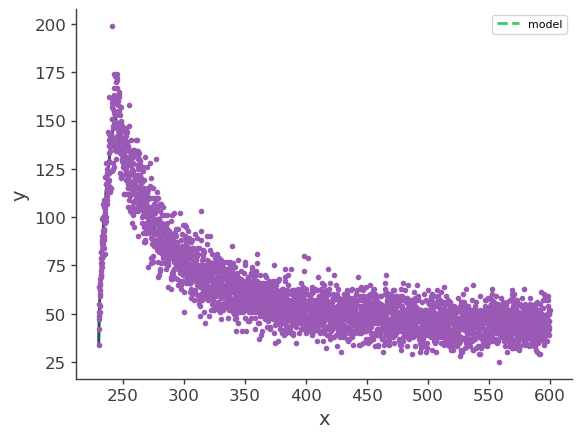

In [92]:
%matplotlib inline
GRBlike.plot()
xx = np.arange(230,300,0.001)
yy = lcmodel(xx)
plt.plot(xx,yy)
plt.show()

00:41:08 ERROR     There were no valid SpectrumLike or FermiLATLike data requested   ]8;id=580466;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/io/plotting/post_process_data_plots.py\post_process_data_plots.py]8;;\:]8;id=251189;file:///data/home/cwy/.mylib/miniconda3/envs/fermi/lib/python3.9/site-packages/threeML/io/plotting/post_process_data_plots.py#109\109]8;;\
                  for plotting. Please use the detector names in the data list                                     

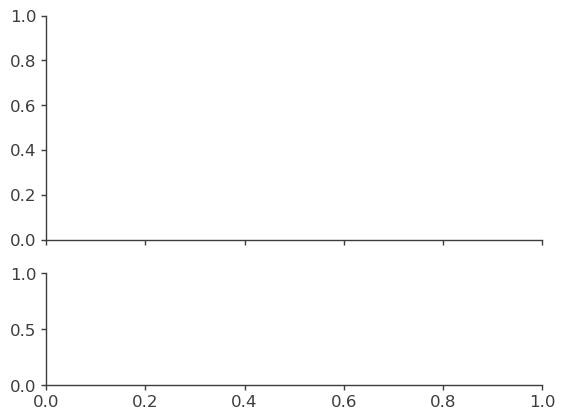

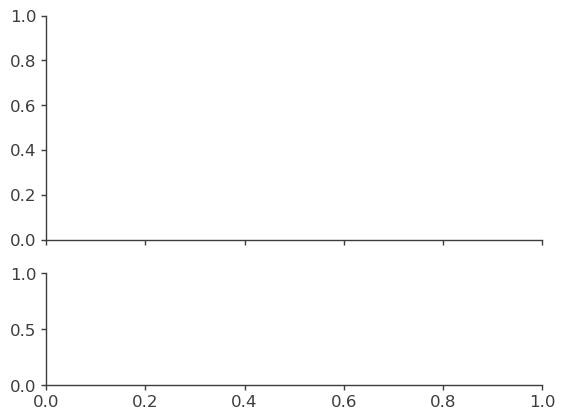